<div><img src="https://www.ibm.com/blogs/bluemix/wp-content/uploads/2017/02/NLU.png", width=170, height=170, align = 'right'> 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png", width = 90, height = 90, align = 'right', style="margin:0px 25px"></div>

# 企业交际费数据分析（案例）

本文演示企业在快速针对交际报销数据进行探索分析时使用的方法。（文中所用为模拟数据）

This notebook runs on Python 3.5 with Spark 2.1.
___________

## 内容列表

1.  [分析流程](#analytic_flow)
2.  [数据洞察概要](#data_insight)
3.  [数据统计](#data_statistics) <br>
 3.1.  [概括性度量](#describe_data) <br>
 3.2.  [历史数据比较](#history_data) <br>
 3.3.  [地域划分统计](#area_data) <br>
 3.4.  [费用类别和地域的关系](#account_data)<br>
 3.5.  [费用类别，用途和部门的关系](#account_data)

<a id="analytic_flow"></a>
## 1. 流程

1. 数据清洗，缺失数据处理等 <br>
2. 数据探索<br>
3. 数据特征展现 <br>

    对象数据抽出条件: <br>
    --------------------------------------------------------  <br>
    礼金<br>
    餐饮<br>
    招待<br>
    等
***

<a id="data_insight"></a>
## 2. 数据洞察概要

-  数据不成正态分布，xxxxxx<br>
-  85%的申请在3000元以下，2万元以上的申请有XX条。
***

<a id="data_statistics"></a>
## 3. 数据统计分析

In [48]:
import brunel
from io import StringIO
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns  
import sys
from pixiedust.display import *
print (sys.getdefaultencoding())

utf-8


In [22]:
# The code was removed by DSX for sharing.

In [23]:
# 加载原始数据
df_data_1 = pd.read_csv(get_object_storage_file_with_credentials_9e4b9e3cb0c64541a038225e909d5e38('MyPython', 'expense_r10.csv'))
df_data_1.head(10)

,﻿APP_NO,EMP_NO,SEC_NAME,TRADE_YEAR,TRADE_MONTH,AMOUNT,LOCATION,ACCOUNT_ITEM,COMMENT
0,74922744,C080,生产管理部,2014,9,112,甘肃,礼品,鲜花
1,74444914,C079,行政部,2014,3,113,四川,礼品,鲜花
2,89094089,A028,生产管理部,2015,11,468,贵州,餐饮,员工聚餐
3,74442024,A021,市场部,2014,2,12346,上海,招待,高尔夫
4,89194018,A021,售后服务部,2015,11,521,四川,餐饮,员工聚餐
5,89029222,A022,售后服务部,2015,10,539,浙江,餐饮,招待
6,74229078,A026,售后服务部,2014,1,8872,上海,招待,高尔夫
7,89040890,B032,行政部,2015,11,544,浙江,餐饮,招待
8,89172227,A030,生产管理部,2014,12,544,江西,餐饮,招待
9,74244902,A028,市场部,2014,6,544,台湾,餐饮,招待


<a id="describe_data"></a>
### 3.1 概括性度量

In [ ]:
df_data_1['AMOUNT'].describe()

#### 数据分布情况直方图探索

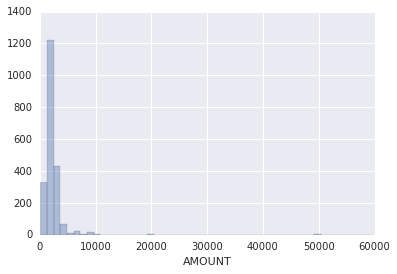

In [33]:
sns.distplot(df_data_1['AMOUNT'],kde = False)
plt.show()

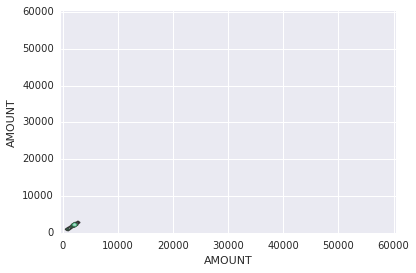

In [35]:
sns.kdeplot(df_data_1['AMOUNT'],df_data_1['AMOUNT'])
plt.show()

#### 针对3000以下数据进一步分布探索

/usr/local/src/conda3_runtime.v21/4.1.1/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


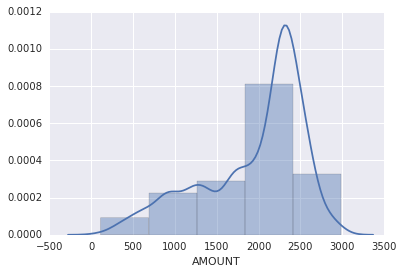

In [28]:
tmp_data_1 = df_data_1.query('AMOUNT <3000')
# tmp_data_1['AMOUNT'] = tmp_data_1['AMOUNT'].astype('float')
sns.distplot(tmp_data_1['AMOUNT'],bins=5,kde=True)
plt.show()

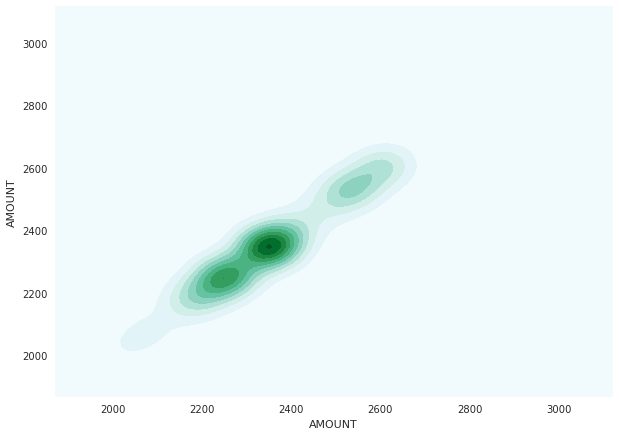

In [42]:
plt.subplots(figsize=(10,7))
sns.kdeplot(tmp_data_1['AMOUNT'],tmp_data_1['AMOUNT'],shade=True)
plt.show()

***

<a id="history_data"></a>
### 3.2. 历史数据比较

#### 选取大于1000元的[餐饮]数据

In [66]:
# 查询2015年度 1000元以上的报销数据,以部门为单位合计
tmp_grouped = df_data_1.query("AMOUNT >1000 & ACCOUNT_ITEM == '餐饮'").groupby(['TRADE_YEAR','TRADE_MONTH','SEC_NAME'], as_index=False).sum()
# 抽取部门名和金额，按金额排序
group_sm = tmp_grouped[['SEC_NAME','TRADE_YEAR','TRADE_MONTH','AMOUNT']].sort_values(['SEC_NAME','TRADE_YEAR','TRADE_MONTH','AMOUNT'])
# 添加区分今年和去年列
group_sm['YEAR']=group_sm["TRADE_YEAR"].map({2015:"今年",2014:"去年"})
group_sm.head(10)

,SEC_NAME,TRADE_YEAR,TRADE_MONTH,AMOUNT,YEAR
0,人力资源部,2014,1,22639,去年
8,人力资源部,2014,2,8141,去年
15,人力资源部,2014,3,10460,去年
23,人力资源部,2014,4,1777,去年
31,人力资源部,2014,5,40808,去年
38,人力资源部,2014,6,12549,去年
47,人力资源部,2014,7,7440,去年
55,人力资源部,2014,8,13826,去年
67,人力资源部,2014,10,45068,去年
75,人力资源部,2014,11,1622,去年


In [67]:
%brunel data('group_sm') sort(YEAR) bar x(SEC_NAME,YEAR) y(AMOUNT) sum(AMOUNT) color(YEAR) sort(AMOUNT) tooltip(TRADE_YEAR,SEC_NAME,AMOUNT) legends(none) interaction(select) title("高额交际费数据分析-往年部门数据比较" ,"1000元以上报销数据":footer) style(".header{font-size:14pt} .footer{font-size:8pt;}")  axes(y:10000:grid:"金额",x:20:"部门") at(0,0,60,100) |  line y(AMOUNT) sum(AMOUNT) x(TRADE_MONTH) color(YEAR) interaction(filter) effect(enter:2000) + y(AMOUNT) x(TRADE_MONTH) color (YEAR) label(AMOUNT) tooltip(SEC_NAME,TRADE_MONTH,AMOUNT) interaction(filter) size(#selection:100%) style(".label{font-size:7pt}") title('  ') axes(x:12:"月份",y:20000:"金额") at(60,10,100,98) :: width=1000, height=300 

<IPython.core.display.Javascript object>

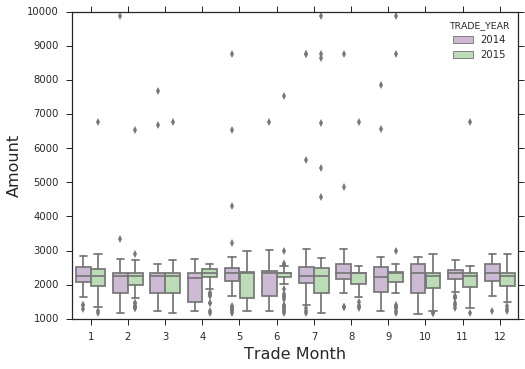

In [100]:
from pylab import mpl  #import matplotlib as mpl 
# myfont = mpl.font_manager.FontProperties(fname='/System/Library/Fonts/ヒラギノ明朝 ProN W6.ttc')  

mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 

tmp_data_1 = df_data_1.query("AMOUNT >1000 & AMOUNT <15000 & ACCOUNT_ITEM == '餐饮' ")
sns.set(style="ticks")                                     #设置主题  
# sns.boxplot(x = csvData['TRADE_MONTH'],y = csvData['AMOUNT_1'] 
sns.boxplot(x = 'TRADE_MONTH',y = 'AMOUNT',hue="TRADE_YEAR",data=tmp_data_1,palette="PRGn")
plt.ylabel("Amount", fontsize="16")
plt.xlabel("Trade Month", fontsize="16")
plt.show()

***

<a id="area_data"></a>
###  3.3. 按地域划分统计

选取2015年度，金额大于1000元的数据

In [69]:
# 查询2015年度 1000元以上的报销数据,以部门为单位合计
tmp_grouped = df_data_1.query("TRADE_YEAR == 2015 & AMOUNT > 1000").groupby(['TRADE_YEAR','LOCATION','ACCOUNT_ITEM'], as_index=False).sum()
# 抽取部门名和金额，按金额排序
group_al = tmp_grouped[['ACCOUNT_ITEM','TRADE_YEAR','LOCATION','AMOUNT']].sort_values(['ACCOUNT_ITEM','TRADE_YEAR','LOCATION','AMOUNT'])
# 添加区分今年和去年列
# group_sl['YEAR']=group_sl["TRADE_YEAR"].map({2015:"今年",2014:"去年"})
group_al.head(10)

# (group_sl[['LOCATION']]).drop_duplicates()

,ACCOUNT_ITEM,TRADE_YEAR,LOCATION,AMOUNT
0,招待,2015,上海,6774
4,招待,2015,云南,3506
16,招待,2015,吉林,96145
36,招待,2015,广东,1751
55,招待,2015,河南,6980
1,礼品,2015,上海,74396
5,礼品,2015,云南,14053
8,礼品,2015,内蒙古,12594
10,礼品,2015,北京,82538
13,礼品,2015,台湾,7033


In [343]:
%brunel data('group_al') map('china') sum(AMOUNT) x(LOCATION) color(AMOUNT) label(LOCATION) tooltip(AMOUNT,#all) legends(auto) interaction(select:mouseover) title("高额交际费数据分析-地域") :: width=800,height=500

<IPython.core.display.Javascript object>

#### 单看下贵州1000元以上的数据

In [83]:
group1 = df_data_1.query("TRADE_YEAR == 2015 & LOCATION == '贵州' & AMOUNT>1000").groupby(['SEC_NAME','ACCOUNT_ITEM','COMMENT'],as_index=False).sum()
# print(group1)
group1.head(10)

,SEC_NAME,ACCOUNT_ITEM,COMMENT,﻿APP_NO,TRADE_YEAR,TRADE_MONTH,AMOUNT
0,人力资源部,礼品,茶叶,74844027,2015,8,1156
1,人力资源部,礼品,香烟,74442822,2015,4,2350
2,人力资源部,礼品,鲜花,163627762,4030,13,2312
3,人力资源部,礼金,员工生日,74441882,2015,4,1679
4,人力资源部,餐饮,员工聚餐,74274288,2015,1,2836
5,公关部,礼品,茶叶,74420224,2015,2,2172
6,公关部,礼品,香烟,1191793960,30225,114,34938
7,公关部,餐饮,员工聚餐,163323374,4030,15,4950
8,公关部,餐饮,招待,416105294,10075,42,9139
9,售后服务部,礼品,消费卡,238884722,6045,27,4990


In [82]:
%brunel data('group1') chord x(ACCOUNT_ITEM) y(SEC_NAME) color(COMMENT) size(AMOUNT) sort(ACCOUNT_ITEM) label(ACCOUNT_ITEM) tooltip(#all) title('高额交际费数据分析') style('.label{font-size: 7pt;text-shadow:none}') interaction(panzoom) :: width=800, height=500

<IPython.core.display.Javascript object>

***

<a id="account_data"></a>
### 3.4 报销类型和地域的关系

In [71]:
%brunel data('group_al') bubble color(ACCOUNT_ITEM,LOCATION) size(AMOUNT) sum(AMOUNT) sort(ACCOUNT_ITEM) label(LOCATION) tooltip(#all) title('高额交际费数据分析-类别与地域') style('.label{font-size: 7pt;text-shadow:none;fill:white}') interaction(panzoom) :: width=800, height=500

<IPython.core.display.Javascript object>

***

### 3.5 费用和部门的关系

In [78]:
df_data = df_data_1.query("LOCATION == '贵州'")
    
line_sec_account_data_tmp = df_data.groupby(['SEC_NAME','ACCOUNT_ITEM']).size().reset_index()
line_sec_account_data_tmp.columns = ['From','To', 'Count']
line_account_comment_data_tmp = df_data.groupby(['ACCOUNT_ITEM','COMMENT']).size().reset_index()
line_account_comment_data_tmp.columns = ['From','To', 'Count']
line_result_1 = pd.concat([line_sec_account_data_tmp, line_account_comment_data_tmp])

#部门数据
node_sec_data_tmp = df_data.groupby(['SEC_NAME']).size().reset_index()
node_sec_data_tmp.insert(1,'部门','部门')
node_sec_data_tmp.columns = ['Node', 'Group', 'Count']
#用途数据
node_account_item_data_tmp = df_data.groupby(['ACCOUNT_ITEM']).size().reset_index()
node_account_item_data_tmp.insert(1,'用途','用途')
node_account_item_data_tmp.columns = ['Node', 'Group', 'Count']
#费用数据
node_comment_data_tmp = df_data.groupby(['COMMENT']).size().reset_index()
node_comment_data_tmp.insert(1,'费用','费用')
node_comment_data_tmp.columns = ['Node', 'Group', 'Count']

node_result_1 = pd.concat([node_sec_data_tmp, node_account_item_data_tmp, node_comment_data_tmp])
print(line_result_1.head())
print(node_result_1.head())



    From  To  Count
0  人力资源部  礼品      8
1  人力资源部  礼金      1
2  人力资源部  餐饮      3
3    公关部  礼品     17
4    公关部  礼金      1
     Node Group  Count
0   人力资源部    部门     12
1     公关部    部门     36
2   售后服务部    部门     32
3     市场部    部门      9
4  新产品研发部    部门     23


In [79]:
%brunel data('line_result_1') edge key(From, To) size(Count)  + data('node_result_1')  network(1.2) key(Node) size(Count) color(Group) label(Node) style("label-location:top") tooltip(Count) title("费用和部门关系图"):: width=800, height=600

<IPython.core.display.Javascript object>

***

### 3.6 聚类模型

In [4]:
# The code was removed by DSX for sharing.

#### 从DSX-Spark中读取模型生成的聚类数据

In [49]:
df_data_2 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(bmos.url('MyPython', 'test_flow_r10'))

In [46]:
df_data_2.show(5)

+--------+------+--------+----------+-----------+------+--------+------------+-------+-----------+
|  APP_NO|EMP_NO|SEC_NAME|TRADE_YEAR|TRADE_MONTH|AMOUNT|LOCATION|ACCOUNT_ITEM|COMMENT|$KM-K-Means|
+--------+------+--------+----------+-----------+------+--------+------------+-------+-----------+
|89094089|  A028|   生产管理部|      2015|         11|   468|      贵州|          餐饮|   员工聚餐|  cluster-1|
|89194018|  A021|   售后服务部|      2015|         11|   521|      四川|          餐饮|   员工聚餐|  cluster-1|
|89029222|  A022|   售后服务部|      2015|         10|   539|      浙江|          餐饮|     招待|  cluster-1|
|89040890|  B032|     行政部|      2015|         11|   544|      浙江|          餐饮|     招待|  cluster-1|
|74284001|  A028|     财务部|      2015|          5|   643|      湖南|          餐饮|   员工聚餐|  cluster-1|
+--------+------+--------+----------+-----------+------+--------+------------+-------+-----------+
only showing top 5 rows



#### 转换下数据类型

In [56]:
print(type(df_data_2))
df_data_3 = df_data_2.toPandas().sort_values('$KM-K-Means')
print(type(df_data_3))

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [57]:
# 讲Amount转换成int类型，方便计算和统计
df_data_3['AMOUNT'] = df_data_3['AMOUNT'].astype(int)
df_data_3.rename(columns={'$KM-K-Means':'K_MEANS'},inplace=True)
# df_data_3.rename(columns=lambda x:x.replace('$',''), inplace=True)

### 小提琴图展现聚类后数据分布

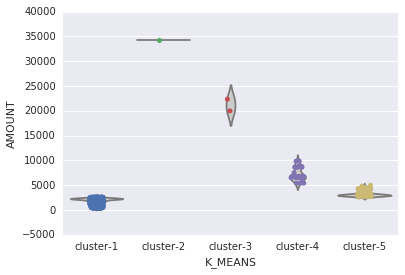

In [58]:
sns.stripplot(x='K_MEANS',y='AMOUNT',data=df_data_3,jitter=True)
sns.violinplot(x="K_MEANS", y="AMOUNT", data=df_data_3,inner=None, color=".8")
plt.show()

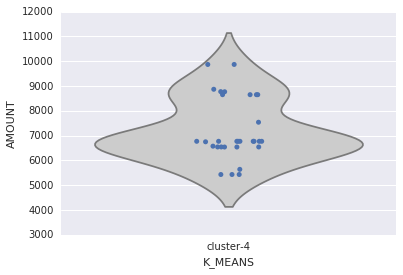

In [59]:
tmp1 = df_data_3.query("K_MEANS == 'cluster-4'")
sns.stripplot(x='K_MEANS',y='AMOUNT',data=tmp1,jitter=True)
sns.violinplot(x="K_MEANS", y="AMOUNT", data=tmp1,inner=None, color=".8")
plt.show()

In [20]:
%brunel data('tmp1') map('china') sum(AMOUNT) x(LOCATION) color(AMOUNT) label(LOCATION) tooltip(AMOUNT,#all) legends(auto) interaction(select:mouseover) title("高额交际费数据分析-地域") :: width=800,height=500

<IPython.core.display.Javascript object>

### 4.详细数据分析

<table align="left">
  <tr>
     <td>NO</td>
     <td>员工号</td>
     <td>申请编号</td>
     <td>特征</td>
  </tr>
  <tr>
     <td>1</td>
     <td>2612WX</td>
     <td>AS7875</td>
     <td>备注栏里填入的内容太过模糊，无法确认该笔经费发生的合理性。</td>
  </tr>
  <tr>
     <td>2</td>
     <td>9115YH</td>
     <td>WE7124</td>
     <td>申请金额超过了会计科目规定的金额。</td>
  </tr>
  <tr>
     <td>3</td>
     <td>2147GB</td>
     <td>CD7681</td>
     <td>申请了大额的餐饮费用但是备注栏里没有明确填写参加人数，无法确认人均经费是否在规定金额以内。</td>
     </tr>
  <tr>
     <td>4</td>
     <td>0987CV</td>
     <td>JN5739</td>
     <td>备注的内容和会计科目相矛盾，故而无法确认经费发生的合理性。</td>
  </tr>
</table>

***
### 作者
**颜 晓超** 是在IBM从事数据分析的高级分析师，有丰富的针对企业客户开发和提供各类数据分析服务经验

Copyright © IBM Corp. 2017. This notebook and its source code are released under the terms of the MIT License.

<div><br><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/IBM_logo.svg/640px-IBM_logo.svg.png" width = 200 height = 200>
</div><br>